In [1]:
import os

print(os.getcwd())
# os.chdir('adversarial_methods')

import cv2
from PIL import Image
from predictor import Predictor
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from scipy.spatial.distance import euclidean

/home/xchen/Projects/XMutant/adversarial_methods


2025-02-25 17:12:26.796601: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-25 17:12:26.873798: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-25 17:12:28.079770: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-02-25 17:12:28.992504: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-02-25 17:12:28.992546: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrievin

Loaded model from disk


In [2]:
result_xmutant = "../XMutant-MNIST/result/digits"
assert os.path.exists(result_xmutant), f"result path {result_xmutant} does not exist"
model_path = "XMutant-MNIST/model"

model = Predictor.model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

In [3]:
import random
def load_mnist_images(data_dir, format='png', max_num=50):
    images = []
    counter = 0
    if format == 'png':
        for filename in os.listdir(data_dir):
            if filename.endswith(".png"):
                img_path = os.path.join(data_dir, filename)
                img = Image.open(img_path).convert('L')  #
                images.append(np.array(img)) # normalization .astype('float32')/255
                counter += 1
            if counter >= max_num:
                break
    elif format == 'npy':
        file_list = os.listdir(data_dir)
        random.shuffle(file_list)
        for filename in file_list:
            if filename.endswith(".npy"):
                img_path = os.path.join(data_dir, filename)
                img = np.load(img_path)

                img = img.squeeze()
                images.append(img)
                counter += 1
            if counter >= max_num:
                break

    print(f"load {len(images)} images from {data_dir} with shape {images[0].shape}, range ({images[0].min()}, {images[0].max()})") # ("images.shape)
    return np.array(images)
#
# image_path_tmp = "./result/deepxplore_digits_occ_mid/digit_0/"
# assert os.path.exists(image_path_tmp), f"image path {image_path_tmp} does not exist"
# images_tmp = load_mnist_images(image_path_tmp)

In [4]:

def preprocess_image(img):
    resized_img = cv2.resize(img, (48, 48))
    rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_GRAY2RGB)
    rgb_img = rgb_img / 255.0 if rgb_img.max() > 10.0 else rgb_img # normalization
    return rgb_img

# preprocessed_images = np.array([preprocess_image(img) for img in images_tmp])

In [5]:
# import tensorflow as tf
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.models import Model

def get_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
    output_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    model = Model(inputs=base_model.input, outputs=output_layer)
    return model

model_vgg = get_vgg16_model()
print("VGG16 model loaded.")

VGG16 model loaded.


In [6]:
# See the summary of the model with our properties.
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [31]:
def get_latent_vector(image_path_tmp, vgg_model, format='png'):
    if not os.path.exists(image_path_tmp):
        return None
    images_tmp = load_mnist_images(image_path_tmp, format)
    print(f"Images loaded. shape {images_tmp.shape} range ({images_tmp.min()}, {images_tmp.max()})")

    preprocessed_images = np.array([preprocess_image(img) for img in images_tmp])
    print(f"Preprocessing completed.r ange ({preprocessed_images.min()}, {preprocessed_images.max()})")

    # get latent vector
    latent_vectors = vgg_model.predict(preprocessed_images, batch_size=64)
    print(f"Latent vectors extracted. shape {latent_vectors.shape}")
    return latent_vectors



In [41]:
latent_vectors_xmutant = np.empty((0,512))
for i in range(10):
    image_path_tmp = os.path.join(result_xmutant, "_C_C_GC")
    latent_vector_tmp = get_latent_vector(image_path_tmp, model_vgg, format='npy')
    print(latent_vector_tmp.shape)
    latent_vectors_xmutant = np.vstack((latent_vectors_xmutant,latent_vector_tmp))

load 50 images from ../XMutant-MNIST/result/digits/_C_C_GC with shape (28, 28), range (0.0, 1.0)
Images loaded. shape (50, 28, 28) range (0.0, 1.0)
Preprocessing completed.r ange (0.0, 1.0)
1/1 [==============================] - 1s 1s/step
Latent vectors extracted. shape (50, 512)
(50, 512)
load 50 images from ../XMutant-MNIST/result/digits/_C_C_GC with shape (28, 28), range (0.0, 1.0)
Images loaded. shape (50, 28, 28) range (0.0, 1.0)
Preprocessing completed.r ange (0.0, 1.0)
1/1 [==============================] - 1s 1s/step
Latent vectors extracted. shape (50, 512)
(50, 512)
load 50 images from ../XMutant-MNIST/result/digits/_C_C_GC with shape (28, 28), range (0.0, 1.0)
Images loaded. shape (50, 28, 28) range (0.0, 1.0)
Preprocessing completed.r ange (0.0, 1.0)
1/1 [==============================] - 1s 1s/step
Latent vectors extracted. shape (50, 512)
(50, 512)
load 50 images from ../XMutant-MNIST/result/digits/_C_C_GC with shape (28, 28), range (0.0, 1.0)
Images loaded. shape (50, 2

In [33]:











latent_vectors_deepxplore = np.empty((0,512))
for i in range(10):
    image_path_tmp = f"./result/deepxplore_digits_/digit_{i}/"

    latent_vector_tmp = get_latent_vector(image_path_tmp, model_vgg)
    if latent_vector_tmp is not None:
        latent_vectors_deepxplore = np.vstack((latent_vectors_deepxplore,latent_vector_tmp))

load 1 images from ./result/deepxplore_digits_/digit_0/ with shape (28, 28), range (0, 255)
Images loaded. shape (1, 28, 28) range (0, 255)
Preprocessing completed.r ange (0.0, 1.0)
1/1 [==============================] - 0s 94ms/step
Latent vectors extracted. shape (1, 512)
load 1 images from ./result/deepxplore_digits_/digit_1/ with shape (28, 28), range (0, 255)
Images loaded. shape (1, 28, 28) range (0, 255)
Preprocessing completed.r ange (0.0, 0.9921568627450981)
1/1 [==============================] - 0s 90ms/step
Latent vectors extracted. shape (1, 512)
load 2 images from ./result/deepxplore_digits_/digit_2/ with shape (28, 28), range (0, 255)
Images loaded. shape (2, 28, 28) range (0, 255)
Preprocessing completed.r ange (0.0, 1.0)
1/1 [==============================] - 0s 123ms/step
Latent vectors extracted. shape (2, 512)
load 2 images from ./result/deepxplore_digits_/digit_3/ with shape (28, 28), range (0, 255)
Images loaded. shape (2, 28, 28) range (0, 255)
Preprocessing compl

In [11]:
latent_vectors_dlfuzz = np.empty((0,512))
for i in range(10):
    image_path_tmp = f"./result/dlfuzz_digits/digit_{i}/"

    latent_vector_tmp = get_latent_vector(image_path_tmp, model_vgg)
    latent_vectors_dlfuzz = np.vstack((latent_vectors_dlfuzz,latent_vector_tmp))

load 50 images from ./result/dlfuzz_digits/digit_0/ with shape (28, 28), range (0, 255)
Images loaded. shape (50, 28, 28) range (0, 255)
Preprocessing completed.
1/1 [==============================] - 1s 1s/step
Latent vectors extracted. shape (50, 512)
load 50 images from ./result/dlfuzz_digits/digit_1/ with shape (28, 28), range (0, 225)
Images loaded. shape (50, 28, 28) range (0, 255)
Preprocessing completed.
1/1 [==============================] - 1s 877ms/step
Latent vectors extracted. shape (50, 512)
load 50 images from ./result/dlfuzz_digits/digit_2/ with shape (28, 28), range (0, 255)
Images loaded. shape (50, 28, 28) range (0, 255)
Preprocessing completed.
1/1 [==============================] - 1s 747ms/step
Latent vectors extracted. shape (50, 512)
load 50 images from ./result/dlfuzz_digits/digit_3/ with shape (28, 28), range (0, 255)
Images loaded. shape (50, 28, 28) range (0, 255)
Preprocessing completed.
1/1 [==============================] - 1s 803ms/step
Latent vectors ex

In [12]:
latent_vectors_fgsm = np.empty((0,512))
for i in range(10):
    image_path_tmp = f"./result/fgsm_digits/digit_{i}/"

    latent_vector_tmp = get_latent_vector(image_path_tmp, model_vgg)
    latent_vectors_fgsm = np.vstack((latent_vectors_fgsm,latent_vector_tmp))

load 50 images from ./result/fgsm_digits/digit_0/ with shape (28, 28), range (0, 255)
Images loaded. shape (50, 28, 28) range (0, 255)
Preprocessing completed.
1/1 [==============================] - 1s 1s/step
Latent vectors extracted. shape (50, 512)
load 50 images from ./result/fgsm_digits/digit_1/ with shape (28, 28), range (0, 255)
Images loaded. shape (50, 28, 28) range (0, 255)
Preprocessing completed.
1/1 [==============================] - 1s 797ms/step
Latent vectors extracted. shape (50, 512)
load 50 images from ./result/fgsm_digits/digit_2/ with shape (28, 28), range (0, 255)
Images loaded. shape (50, 28, 28) range (0, 255)
Preprocessing completed.
1/1 [==============================] - 1s 876ms/step
Latent vectors extracted. shape (50, 512)
load 50 images from ./result/fgsm_digits/digit_3/ with shape (28, 28), range (0, 255)
Images loaded. shape (50, 28, 28) range (0, 255)
Preprocessing completed.
1/1 [==============================] - 1s 898ms/step
Latent vectors extracted.

In [13]:
from utils import set_all_seeds, load_mnist_test

latent_vectors_original = np.empty((0,512))
for i in range(10):
    x_test, _ = load_mnist_test(popsize=50, number=i)
    print(f"x_test shape: {x_test.shape}, range: ({x_test.min()}, {x_test.max()})")

    preprocessed_images = np.array([preprocess_image(img) for img in x_test])
    print(f"preprocessed_images shape: {preprocessed_images.shape}, range: ({preprocessed_images.min()}, {preprocessed_images.max()})")

    # get latent vector
    latent_vector_tmp = model_vgg.predict(preprocessed_images, batch_size=64)

    latent_vectors_original = np.vstack((latent_vectors_original,latent_vector_tmp))


x_test shape: (50, 28, 28), range: (0, 255)
preprocessed_images shape: (50, 48, 48, 3), range: (0.0, 1.0)
1/1 [==============================] - 1s 1s/step
x_test shape: (50, 28, 28), range: (0, 255)
preprocessed_images shape: (50, 48, 48, 3), range: (0.0, 1.0)
1/1 [==============================] - 1s 731ms/step
x_test shape: (50, 28, 28), range: (0, 255)
preprocessed_images shape: (50, 48, 48, 3), range: (0.0, 1.0)
1/1 [==============================] - 1s 692ms/step
x_test shape: (50, 28, 28), range: (0, 255)
preprocessed_images shape: (50, 48, 48, 3), range: (0.0, 1.0)
1/1 [==============================] - 1s 791ms/step
x_test shape: (50, 28, 28), range: (0, 255)
preprocessed_images shape: (50, 48, 48, 3), range: (0.0, 1.0)
1/1 [==============================] - 1s 810ms/step
x_test shape: (50, 28, 28), range: (0, 255)
preprocessed_images shape: (50, 48, 48, 3), range: (0.0, 1.0)
1/1 [==============================] - 1s 830ms/step
x_test shape: (50, 28, 28), range: (0, 255)
prepr

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print(f"latent vector shapes: Xmutant {latent_vectors_xmutant.shape}, "
      f"DeepXplore {latent_vectors_deepxplore.shape}, "
      f"DLFuzz {latent_vectors_dlfuzz.shape}, "
      f"FGSM {latent_vectors_fgsm.shape}"
      f"Original {latent_vectors_original.shape}")
latent_vectors_all = np.vstack([latent_vectors_xmutant,
                                latent_vectors_deepxplore,
                                latent_vectors_dlfuzz,
                                latent_vectors_fgsm,
                                latent_vectors_original])
labels =  np.array([0] * latent_vectors_xmutant.shape[0] +
                   [1] * latent_vectors_deepxplore.shape[0] +
                   [2] * latent_vectors_dlfuzz.shape[0] +
                   [3] * latent_vectors_fgsm.shape[0] +
                   [4] * latent_vectors_original.shape[0])

def dimension_reduction(latent_vectors, method='pca', dimension=2):
    if method == 'pca':
        # PCA 降维到 2D
        reduced_vectors = PCA(n_components=dimension).fit_transform(latent_vectors)
    elif method == 'tsne':
        # t-SNE 降维到 2D
        reduced_vectors = TSNE(n_components=dimension, perplexity=30, n_iter=600).fit_transform(latent_vectors)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")

    return reduced_vectors


# visualize_latent_vectors(latent_vectors_deepxplore, method='pca')  # or 'tsne'

def plot_reduced_vectors(reduced_vectors, labels,method):
    plt.figure(figsize=(8, 4))

    plt.scatter(
        reduced_vectors[labels == 2, 0],
        reduced_vectors[labels == 2, 1],
        color='green',
        alpha=0.4,
        label='DLFuzz',
        marker = 'v'
    )

    plt.scatter(
        reduced_vectors[labels == 3, 0],
        reduced_vectors[labels == 3, 1],
        color='red',
        alpha=0.4,
        label='FGSM',
        marker = '^'
    )
    plt.scatter(
        reduced_vectors[labels == 1, 0],
        reduced_vectors[labels == 1, 1],
        color='black',
        alpha=1,
        label='DeepXplore',
        marker = 'x'
    )
    plt.scatter(
        reduced_vectors[labels == 0, 0],
        reduced_vectors[labels == 0, 1],
        color='blue',
        alpha=0.4,
        label='Xmutant',
        marker='o'
    )

    plt.scatter(
        reduced_vectors[labels == 4, 0],
        reduced_vectors[labels == 4, 1],
        color='orange',
        alpha=0.6,
        label='Original',
        marker='.'
    )
    plt.title(f"{method.upper()} Visualization of Latent Vectors")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

    plt.legend(labels = ['DLFuzz', 'FGSM', 'DeepXplore', 'XMutant', 'Original'], # title="Configurations",
               loc="center left", bbox_to_anchor=(1.02, 0.5))
    # plt.tight_layout(rect=[0, 0, , 1])
    # plt.legend()
    plt.grid(True)
    # plt.savefig("pca.svg", format="svg", bbox_inches = "tight")
    plt.show()


latent vector shapes: Xmutant (500, 512), DeepXplore (44, 512), DLFuzz (500, 512), FGSM (500, 512)Original (500, 512)


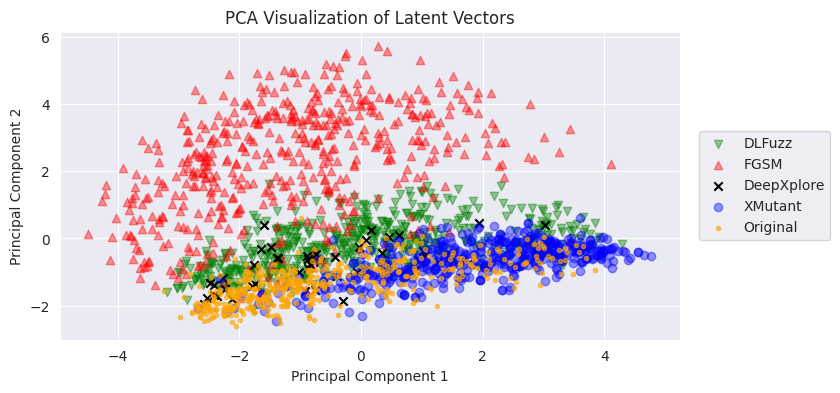

In [35]:
method = 'pca'
reduced_vectors_pca_2d = dimension_reduction(latent_vectors_all, method=method)
plot_reduced_vectors(reduced_vectors_pca_2d, labels,method)

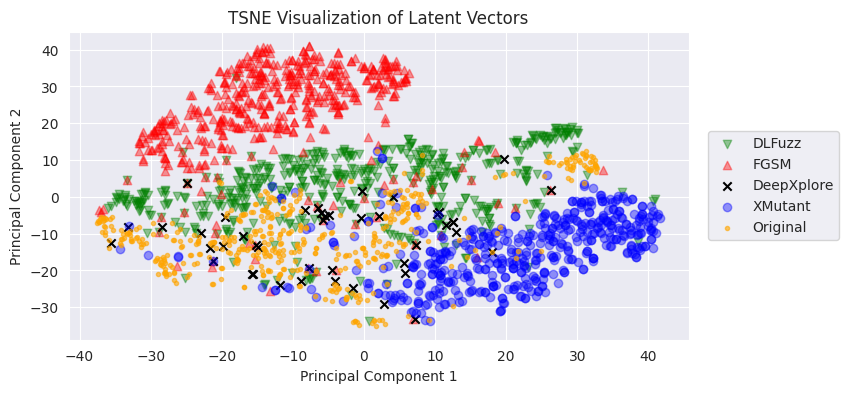

In [16]:
# record the least distance to original and take the average
method = 'tsne'
reduced_vectors_tsne_2d = dimension_reduction(latent_vectors_all, method=method)
plot_reduced_vectors(reduced_vectors_tsne_2d , labels,method)

In [17]:
def analyze_statistics(latent_vectors, dataset):
    mean = np.mean(latent_vectors, axis=0)
    std_dev = np.std(latent_vectors, axis=0)
    min_val = np.min(latent_vectors, axis=0)
    max_val = np.max(latent_vectors, axis=0)

    print(dataset + "Latent Vector Statistics:")
    print(f"Mean: {mean[:5]} ...")  # 只显示前5维
    print(f"Standard Deviation: {std_dev[:5]} ...")
    print(f"Min: {min_val[:5]} ...")
    print(f"Max: {max_val[:5]} ...")
    return mean, std_dev
mean_deepxplore, std_deepxplore = analyze_statistics(latent_vectors_deepxplore, "DeepXplore")
mean_dlfuzz, std_dlfuzz = analyze_statistics(latent_vectors_dlfuzz, "DLFuzz")
mean_fgsm, std_fgsm = analyze_statistics(latent_vectors_fgsm, "FGSM")
mean_xmutant, std_xmutant = analyze_statistics(latent_vectors_xmutant, "Xmutant")
mean_original, std_original = analyze_statistics(latent_vectors_original, "Original")

mean_list = [mean_deepxplore, mean_dlfuzz, mean_fgsm, mean_xmutant]
approaches_list = ["DeepXplore", "DLFuzz", "FGSM", "Xmutant"]
for mean_, approach in zip(mean_list, approaches_list):
    print(f"=============Statistical test for Approach: {approach}==============")
    distance = euclidean(mean_, mean_original)
    print(f"Distance between groups {approach} to original set: {distance}")

DeepXploreLatent Vector Statistics:
Mean: [0.09986407 0.         0.16640887 0.05273394 0.2132359 ] ...
Standard Deviation: [0.1548017  0.         0.22783493 0.09407835 0.38574446] ...
Min: [0. 0. 0. 0. 0.] ...
Max: [0.56639707 0.         1.22346282 0.34953132 1.42687225] ...
DLFuzzLatent Vector Statistics:
Mean: [0.0719515  0.         0.09008373 0.0520003  0.14905411] ...
Standard Deviation: [0.12839233 0.         0.14352802 0.08446323 0.2607578 ] ...
Min: [0. 0. 0. 0. 0.] ...
Max: [0.78200412 0.         0.83988369 0.49716783 1.26900053] ...
FGSMLatent Vector Statistics:
Mean: [0.12496056 0.         0.1262745  0.18142804 0.02540547] ...
Standard Deviation: [0.19110916 0.         0.19438688 0.18809271 0.11738023] ...
Min: [0. 0. 0. 0. 0.] ...
Max: [1.03943253 0.         1.36726344 1.05866814 1.56727493] ...
XmutantLatent Vector Statistics:
Mean: [0.11722014 0.         0.03343875 0.02345974 0.26856937] ...
Standard Deviation: [0.18743954 0.         0.09832704 0.05710388 0.33862617] ...
M

In [18]:
reduced_vectors_tsne_1d = dimension_reduction(latent_vectors_all, method='tsne', dimension=1)
reduced_vectors_pca_1d = dimension_reduction(latent_vectors_all, method='pca', dimension=1)
print(reduced_vectors_pca_1d.shape)


(2044, 1)


In [18]:
def analyze_statistics(latent_vectors, dataset):
    mean = np.mean(latent_vectors, axis=0)
    std_dev = np.std(latent_vectors, axis=0)
    min_val = np.min(latent_vectors, axis=0)
    max_val = np.max(latent_vectors, axis=0)

    print(dataset + "Latent Vector Statistics:")
    print(f"Mean: {mean}", f"Standard Deviation: {std_dev} ", f"Min: {min_val}", f"Max: {max_val}")

analyze_statistics(reduced_vectors_pca_1d[labels == 1], "DeepXplore")
analyze_statistics(reduced_vectors_pca_1d[labels == 2], "DLFuzz")
analyze_statistics(reduced_vectors_pca_1d[labels == 3], "FGSM")
analyze_statistics(reduced_vectors_pca_1d[labels == 0], "Xmutant")
analyze_statistics(reduced_vectors_pca_1d[labels == 4], "Original")
print("--------------------------------------------------")
analyze_statistics(reduced_vectors_tsne_1d[labels == 1], "DeepXplore")
analyze_statistics(reduced_vectors_tsne_1d[labels == 2], "DLFuzz")
analyze_statistics(reduced_vectors_tsne_1d[labels == 3], "FGSM")
analyze_statistics(reduced_vectors_tsne_1d[labels == 0], "Xmutant")
analyze_statistics(reduced_vectors_tsne_1d[labels == 4], "Original")

DeepXploreLatent Vector Statistics:
Mean: [-0.64787598] Standard Deviation: [1.37851741]  Min: [-2.66651445] Max: [3.26742711]
DLFuzzLatent Vector Statistics:
Mean: [0.10593375] Standard Deviation: [1.76538658]  Min: [-3.18634215] Max: [4.46868534]
FGSMLatent Vector Statistics:
Mean: [-0.63195048] Standard Deviation: [1.74199946]  Min: [-4.1870469] Max: [4.56991143]
XmutantLatent Vector Statistics:
Mean: [1.14824847] Standard Deviation: [1.78980841]  Min: [-2.70460908] Max: [4.51212044]
OriginalLatent Vector Statistics:
Mean: [-0.56521866] Standard Deviation: [1.67978662]  Min: [-3.43195657] Max: [4.03451908]
--------------------------------------------------
DeepXploreLatent Vector Statistics:
Mean: [2.4667854] Standard Deviation: [12.426961]  Min: [-18.561808] Max: [29.681572]
DLFuzzLatent Vector Statistics:
Mean: [8.640098] Standard Deviation: [17.879293]  Min: [-31.810844] Max: [42.03117]
FGSMLatent Vector Statistics:
Mean: [-27.787165] Standard Deviation: [13.533702]  Min: [-42.09

In [19]:
from stat_tests import run_wilcoxon_and_cohend


approaches = ['Xmutant', 'DeepXplore', 'DLFuzz', 'FGSM']

for lab, approach  in enumerate(approaches):
    print(f"=============Statistical test for Approach: {approach}==============")
    list1 = reduced_vectors_pca_1d[labels == lab]
    random.shuffle(list1)
    list2 = reduced_vectors_pca_1d[labels == 4]
    random.shuffle(list2)
    leng = 44#min(list1.shape[0], list2.shape[0])

    pvalue, cohensd = run_wilcoxon_and_cohend(list1[:leng], list2[:leng])


=============Statistical test for Approach: Xmutant==============
statistic is: [0.] P-Value is: [1.13686838e-13]
Cohen's D is: ('large', 2.5082522305216433)
=============Statistical test for Approach: DeepXplore==============
statistic is: [101.] P-Value is: [5.92033757e-07]
Cohen's D is: ('large', 1.2522484929148494)
=============Statistical test for Approach: DLFuzz==============
statistic is: [216.] P-Value is: [0.00081806]
Cohen's D is: ('large', 0.8006724884591984)
=============Statistical test for Approach: FGSM==============
statistic is: [291.] P-Value is: [0.01649811]
Cohen's D is: ('small', 0.3397193323040143)


In [20]:
for lab, approach  in enumerate(approaches):
    print(f"=============Statistical test for Approach: {approach}==============")
    list1 = reduced_vectors_tsne_1d[labels == lab]
    random.shuffle(list1)
    list2 = reduced_vectors_tsne_1d[labels == 4]
    random.shuffle(list2)
    leng = 44#min(list1.shape[0], list2.shape[0])

    pvalue, cohensd = run_wilcoxon_and_cohend(list1[:leng], list2[:leng])

=============Statistical test for Approach: Xmutant==============
statistic is: [0.] P-Value is: [1.13686838e-13]
Cohen's D is: ('large', 3.676611358918064)
=============Statistical test for Approach: DeepXplore==============
statistic is: [1.] P-Value is: [2.27373675e-13]
Cohen's D is: ('large', 2.1014550562257397)
=============Statistical test for Approach: DLFuzz==============
statistic is: [480.] P-Value is: [0.86696521]
Cohen's D is: ('small', 0.44830723408903556)
=============Statistical test for Approach: FGSM==============
statistic is: [75.] P-Value is: [5.57084832e-08]
Cohen's D is: ('large', 1.3126689093135355)


In [21]:
for lab, approach  in enumerate(approaches):
    print(f"=============Statistical test for Approach: {approach}==============")
    list1 = reduced_vectors_tsne_2d[labels == lab, 0]
    random.shuffle(list1)
    list2 = reduced_vectors_tsne_2d[labels == 4, 0]
    random.shuffle(list2)
    leng = 44#min(list1.shape[0], list2.shape[0])

    pvalue, cohensd = run_wilcoxon_and_cohend(list1[:leng], list2[:leng])


=============Statistical test for Approach: Xmutant==============
statistic is: 214.0 P-Value is: 0.000743958695238689
Cohen's D is: ('large', 0.84239880368736)
=============Statistical test for Approach: DeepXplore==============
statistic is: 430.0 P-Value is: 0.45537780267716244
Cohen's D is: ('negligible', 0.14854557195830062)
=============Statistical test for Approach: DLFuzz==============
statistic is: 326.0 P-Value is: 0.04855626556422976
Cohen's D is: ('medium', 0.5136301467762537)
=============Statistical test for Approach: FGSM==============
statistic is: 379.0 P-Value is: 0.1794750311541975
Cohen's D is: ('small', 0.33084956510563185)


In [22]:
for lab, approach  in enumerate(approaches):
    print(f"=============Statistical test for Approach: {approach}==============")
    list1 = reduced_vectors_tsne_2d[labels == lab, 1]
    random.shuffle(list1)
    list2 = reduced_vectors_tsne_2d[labels == 4, 1]
    random.shuffle(list2)
    leng = 44#min(list1.shape[0], list2.shape[0])

    pvalue, cohensd = run_wilcoxon_and_cohend(list1[:leng], list2[:leng])

=============Statistical test for Approach: Xmutant==============
statistic is: 319.0 P-Value is: 0.03970191429891656
Cohen's D is: ('small', 0.4691828901447178)
=============Statistical test for Approach: DeepXplore==============
statistic is: 353.0 P-Value is: 0.09899713914114727
Cohen's D is: ('small', 0.3090163536019339)
=============Statistical test for Approach: DLFuzz==============
statistic is: 150.0 P-Value is: 2.13862452937974e-05
Cohen's D is: ('large', 1.0850289498973538)
=============Statistical test for Approach: FGSM==============
statistic is: 18.0 P-Value is: 2.8762769943568856e-11
Cohen's D is: ('large', 2.371625068078542)


In [23]:
from scipy.spatial.distance import euclidean
for lab, approach  in enumerate(approaches):
    print(f"=============Statistical test for Approach: {approach}==============")
    list1 = reduced_vectors_tsne_2d[labels == lab]
    group1_center = np.mean(list1, axis=0)
    print(group1_center)
    list2 = reduced_vectors_tsne_2d[labels == 4, :]
    group2_center = np.mean(list2, axis=0)
    distence = euclidean(group1_center, group2_center)
    print(f"Distance between groups {approach} to original set: {distence}")

=============Statistical test for Approach: Xmutant==============
[ 11.790358 -15.138579]
Distance between groups Xmutant to original set: 19.842390060424805
=============Statistical test for Approach: DeepXplore==============
[ -7.675502 -12.238206]
Distance between groups DeepXplore to original set: 1.933737874031067
=============Statistical test for Approach: DLFuzz==============
[1.1621567 2.906526 ]
Distance between groups DLFuzz to original set: 15.784530639648438
=============Statistical test for Approach: FGSM==============
[-5.2514644 24.96104  ]
Distance between groups FGSM to original set: 35.34675598144531


In [24]:
def mean_nearest_neighbor_distance(group1, group2):
    distances = []
    for p2 in group2:

        dists = np.linalg.norm(group1 - p2, axis=1)
        nearest_dist = np.min(dists)
        distances.append(nearest_dist)
    return np.mean(distances)

def bidirectional_mean_nnd(group1, group2):
    mean_dist_1_to_2 = mean_nearest_neighbor_distance(group1, group2)
    mean_dist_2_to_1 = mean_nearest_neighbor_distance(group2, group1)
    return mean_dist_1_to_2, mean_dist_2_to_1

for lab, approach  in enumerate(approaches):
    print(f"=============Statistical test for Approach: {approach}==============")

    mean_1_to_2, mean_2_to_1 = bidirectional_mean_nnd(reduced_vectors_tsne_2d[labels == 4], reduced_vectors_tsne_2d[labels == lab])
    print(f"Distance between groups {approach} to original set:  {mean_1_to_2} and {mean_2_to_1}")

=============Statistical test for Approach: Xmutant==============
Distance between groups Xmutant to original set:  4.428260803222656 and 2.9172418117523193
=============Statistical test for Approach: DeepXplore==============
Distance between groups DeepXplore to original set:  1.9715297222137451 and 4.773562431335449
=============Statistical test for Approach: DLFuzz==============
Distance between groups DLFuzz to original set:  4.12145471572876 and 3.1213130950927734
=============Statistical test for Approach: FGSM==============
Distance between groups FGSM to original set:  20.83022689819336 and 4.322683811187744


In [25]:
for lab, approach  in enumerate(approaches):
    print(f"=============Statistical test for Approach: {approach}==============")

    mean_1_to_2, mean_2_to_1 = bidirectional_mean_nnd(reduced_vectors_pca_2d[labels == 4], reduced_vectors_pca_2d[labels == lab])
    print(f"Distance between groups {approach} to original set:  {mean_1_to_2} and {mean_2_to_1}")

=============Statistical test for Approach: Xmutant==============
Distance between groups Xmutant to original set:  0.1091364053289278 and 0.11788001556363799
=============Statistical test for Approach: DeepXplore==============
Distance between groups DeepXplore to original set:  0.13976708022161086 and 0.34715105816516395
=============Statistical test for Approach: DLFuzz==============
Distance between groups DLFuzz to original set:  0.27704296997886846 and 0.2246899473779962
=============Statistical test for Approach: FGSM==============
Distance between groups FGSM to original set:  2.4976203558892665 and 0.4826952760423905


In [26]:
for lab, approach  in enumerate(approaches):
    print(f"=============Statistical test for Approach: {approach}==============")

    mean_1_to_2, mean_2_to_1 = bidirectional_mean_nnd(reduced_vectors_pca_2d[labels == 4], reduced_vectors_pca_2d[labels == lab])
    print(f"Distance between groups {approach} to original set:  {mean_1_to_2} and {mean_2_to_1}")

=============Statistical test for Approach: Xmutant==============
Distance between groups Xmutant to original set:  0.1091364053289278 and 0.11788001556363799
=============Statistical test for Approach: DeepXplore==============
Distance between groups DeepXplore to original set:  0.13976708022161086 and 0.34715105816516395
=============Statistical test for Approach: DLFuzz==============
Distance between groups DLFuzz to original set:  0.27704296997886846 and 0.2246899473779962
=============Statistical test for Approach: FGSM==============
Distance between groups FGSM to original set:  2.4976203558892665 and 0.4826952760423905


In [27]:
dis1, dis2 = bidirectional_mean_nnd(latent_vectors_original, latent_vectors_xmutant)
print(f"Distance between groups Xmutant to original set:  {dis1} and {dis2}")
dis1, dis2 = bidirectional_mean_nnd(latent_vectors_original, latent_vectors_fgsm)
print(f"Distance between groups FGSM to original set:  {dis1} and {dis2}")
dis1, dis2 = bidirectional_mean_nnd(latent_vectors_original, latent_vectors_dlfuzz)
print(f"Distance between groups DLFuzz to original set:  {dis1} and {dis2}")
dis1, dis2 = bidirectional_mean_nnd(latent_vectors_original, latent_vectors_deepxplore)
print(f"Distance between groups DeepXplore to original set:  {dis1} and {dis2}")


Distance between groups Xmutant to original set:  2.782211375864641 and 2.682359189732763
Distance between groups FGSM to original set:  4.785545873489847 and 3.2749028435197323
Distance between groups DLFuzz to original set:  2.871560697327553 and 2.730015230996206
Distance between groups DeepXplore to original set:  2.9787602918614224 and 3.1957719174621424


In [25]:

from prdc import compute_prdc

nearest_k = 5


In [36]:
metrics = compute_prdc(real_features=latent_vectors_original,
                       fake_features=latent_vectors_dlfuzz,
                       nearest_k=nearest_k)
print(f"Result of DLFuzz to original set:  {metrics} ")

Num real: 500 Num fake: 500
Result of DLFuzz to original set:  {'precision': 0.458, 'recall': 0.712, 'density': 0.1968, 'coverage': 0.394} 


In [37]:
metrics = compute_prdc(real_features=latent_vectors_original,
                       fake_features=latent_vectors_deepxplore,
                       nearest_k=nearest_k)
print(f"Result of DeepXplore to original set:  {metrics} ")


Num real: 500 Num fake: 44
Result of DeepXplore to original set:  {'precision': 0.3181818181818182, 'recall': 0.922, 'density': 0.2090909090909091, 'coverage': 0.08} 


In [38]:
metrics = compute_prdc(real_features=latent_vectors_original,
                       fake_features=latent_vectors_xmutant,
                       nearest_k=nearest_k)
print(f"Result of Xmutant to original set:  {metrics} ")

Num real: 500 Num fake: 500
Result of Xmutant to original set:  {'precision': 0.564, 'recall': 0.626, 'density': 0.35800000000000004, 'coverage': 0.43} 


In [39]:
metrics = compute_prdc(real_features=latent_vectors_original,
                       fake_features=latent_vectors_fgsm,
                       nearest_k=nearest_k)
print(f"Result of FGSM to original set:  {metrics} ")

Num real: 500 Num fake: 500
Result of FGSM to original set:  {'precision': 0.03, 'recall': 0.878, 'density': 0.0128, 'coverage': 0.062} 
